# **QnA over PDF Report with LLM**

## **Opening**

### Problem Background

Reports, as a form of written document, are used in many sectors, such as the financial sector. In the context of finance and banking, reports are written to summarize information and analysis results related to a financial activity. These reports may cover various aspects, such as financial position, operating results, cash flow, and investment performance analysis. In general, financial statements are designed to provide stakeholders with an overview of the financial condition of an organization or company.

In practice, reports often contain very detailed and comprehensive information. This makes the documents tend to be thick and complex, so finding the specific information needed can be a challenge. The thickness and complexity of these reports are often due to the need to cover all relevant aspects and present data and analysis comprehensively to ensure that readers gain a complete understanding of the subject at hand.

### LLM and RAG

With the development of artificial intelligence (AI) and machine learning (ML) technology, we can streamline the search for information contained in tens or even hundreds of pages of reports using large language model (LLM). LLM is an application of AI where the model is "trained" on large amounts of text data so that the model can understand the context contained in the text. Furthermore, LLM can generate content based on the previously learned context. An example of LLM that is currently widely used is ChatGPT.

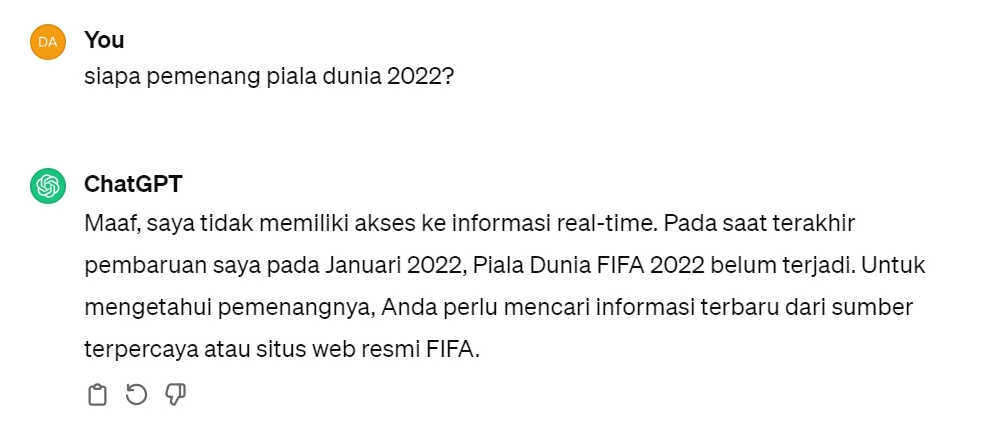

LLM has superior performance for generalized knowledge. However, LLM has a knowledge cutoff. In this case, LLM only has knowledge up to a certain time span. If we ask beyond the knowledge cutoff, LLM will not know the answer to the given question and end up producing a wrong answer (hallucinating). Starting from this limitation, the concept of RAG or retrieval augmented generation emerged.

RAG works with the concept of providing additional context to LLM. With RAG, we can extend the ability of LLM past its knowledge cutoff. In addition, we can also apply LLM for more specific tasks, such as creating a question-answer system on a document, to solve the problem that became our concern at the beginning of this writing. 

In this article, we will create a QnA system with LLM using the RAG concept. In this case, the report file will be an additional knowledge for the LLM. Furthermore, we can ask specific questions related to the report to the LLM.

## **QnA with PDF using LangChain**

### LangChain

LangChain is a framework used to develop applications based on LLMs. LangChain provides functionality that allows us to access various LLMs, such as ChatGPT from OpenAI and Gemini from Google. With the flexibility of LangChain, we can customize the LLM application according to the requirements we want to meet.

### How Does The System Work?

Before implementing the code with LangChain, we will explore the flow of how LLM can answer a given question according to the context of the given document. In this case, we focus on building a QnA system to streamline information navigation.

<img src="assets/rag_workflow.png">

**1. Loading**

In the first step, we need to load the data source that becomes the additional context for LLM. These data sources can be various, such as web pages, CSV files, PDF files, and databases. In this article, we will use a data source in the form of a report in PDF format.

**2. Splitting**

The previously loaded document is composed of many characters. This will make it difficult for the model to process the document. Therefore, we need to split the document into smaller chunks that are easier to process. 

**3. Embedding**

Furthermore, a set of chunks derived from a document will be represented in the form of numbers. This representation of text in the form of numbers is also known as embedding.

**4. Storing**

The embedding that has been formed in the previous stage will be stored in a database, which is also called a vector database. Vector database can be imagined as a library that includes the information in our previous report. LLM will search for answers related to the report in the vector database. In this case, the vector database provides more specific context in addition to the general knowledge that LLM already has.

<img src="assets/rag_workflow2.png">




**5. Retrieving and Generating**

When we provide a question, also known as a query, to LLM, the question will be converted into a numerical representation. This numerical representation will be used to search for the corresponding answer from the vector database. This process involves calculating the vector similarity between the vector of the query and the vector of information contained in the vector database. The information with the highest similarity will be returned as the answer.

#

### Code

Let's implement the workflow we learned earlier with LangChain. First, we will import all the necessary packages. Subsequently, we will load OpenAI API credential within `.env` file.

In [1]:
# loading PDF
from langchain_community.document_loaders import PyPDFLoader
# splitting PDF
from langchain.text_splitter import RecursiveCharacterTextSplitter
# generating embedding
from langchain_openai import OpenAIEmbeddings
# storing embedding
from langchain_community.vectorstores import Chroma
# preparing prompt
from langchain_core.prompts import PromptTemplate
# LLM
from langchain_openai import ChatOpenAI
# passing the query
from langchain_core.runnables import RunnablePassthrough
# parsing the output
from langchain_core.output_parsers import StrOutputParser

In [2]:
# please provide your OpenAI API key
from dotenv import load_dotenv

load_dotenv()

True

After making sure all the tools we will use are loaded properly, we will load PDF data with the `PyPDFLoader` module. Besides `PyPDFLoader`, LangChain provides several modules for loading PDF data, such as `MathpixPDFLoader`, `UnstructuredPDFLoader`, and `PyPDFium2`.

In this article, we will use Bank BCA's 2023 financial report file which consists of 747 pages.

In [3]:
# 1. Loading
loader = PyPDFLoader("assets/BCA_2023.pdf")
data = loader.load()

In [4]:
type(data)

list

In [5]:
len(data)

747

In [6]:
data[0]

Document(page_content='Unleashing Potential, Delivering Value LAPORAN TAHUNAN 2023\nUnleashing Potential, \nDelivering ValuePT BANK CENTRAL ASIA TBK\nLAPORAN\nTAHUNAN \n2023', metadata={'source': 'assets/BCA_2023.pdf', 'page': 0})

With the above code, our PDF file will be converted into a list with the same number of elements as the PDF file. In each element, there will be the content of the PDF page and metadata indicating the location of the content page in the PDF file.

In the next stage, we will be processing the document. In this case, the large document will be divided into smaller chunks. We use `RecursiveCharacterTextSplitter` which creates chunks based on the number of characters. For example, here we define for each chunk there are 450 characters. Between one chunk and another chunk there are 80 characters in common. This is to maintain the context between one part of the text and another.

In [7]:
# 2. Splitting
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 450, chunk_overlap = 80)
splits = text_splitter.split_documents(data)

In [8]:
len(splits)

6402

At the end of the splitting process, we get 6402 chunks. These chunks with more maintainable lengths are then stored in the vector database. The vector database that will be used is `Chroma`. `Chroma` requires two things as input:

1. The documents to be stored. In this case, it is the result of the previous splitting process.
2. The embedding model. In this case, the model used to convert text into numeric representation. LangChain provides many embedding models. The choice of embedding to be used depends on the LLM to be used. We will use OpenAI's LLM so we also use OpenAI's embedding model.

In [9]:
# 3. Embedding 
# 4. Storing
vectorstore = Chroma.from_documents(documents = splits, 
                                    embedding = OpenAIEmbeddings(model = "text-embedding-3-large"))

In order to create QnA tools, we need to define a chain. A chain can be envisioned as a system consisting of a set of rules and tools to produce a desired output. Simply put, we direct LLM to provide the correct output according to the given context and input.

The chain we will use consists of several elements:

1. A template that directs what kind of output should be issued by LLM. 
2. An LLM model that will provide answers that match the template.
3. An output parser to retrieve the output of the LLM.

In [10]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [11]:
template = """Use the following pieces of context to answer the question at the end.
    If you don't know the answer, just say that you don't know, don't try to make up an answer.
    Use three sentences minimum and give the answer in the complete way.
    Always say "thanks for asking!" at the end of the answer.

    {context}

    Question: {question}

    Helpful Answer:"""

Note that with the above template, we direct LLM to answer based on the given context (`{context}`). The `{context}` is a placeholder to store the context. The context will be provided when a code to insert a value into the placeholder is executed. The same is true for `{question}`.

Take a look at the code below!

* For `context`, the value provided is the value from the vector database.
* For `question`, the value given is the question given by the user when running the *chain* with the `.invoke()` command.

In addition to the template, we also define the LLM that will answer the given question. The model used is `ChatOpenAI` version GPT 3.5. In addition, we also define the parameter `temperature = 0`. The parameter `temperature` is used to set the creativity level of the model in answering a question. When we set this parameter to 0, we expect the model to answer based on the given context and not "make up" other answers.

In [12]:
retriever = vectorstore.as_retriever()
custom_rag_prompt = PromptTemplate.from_template(template)
llm = ChatOpenAI(model_name = 'gpt-3.5-turbo-0125', temperature = 0)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | llm
    | StrOutputParser()
) 


Once the chain is defined, we can use it by providing queries through the `.invoke()` command like the example below.

In [13]:
rag_chain.invoke("Apa judul dokumen ini?")

'Dokumen ini berjudul "Keputusan Rapat Komite Audit dan Komite Pemantau Risiko". Dokumen ini membahas tentang tugas, tanggung jawab, wewenang, dan hasil perhitungan suara terkait dengan keputusan yang diambil dalam rapat Komite Audit dan Komite Pemantau Risiko. Terima kasih atas pertanyaannya!'

In [14]:
rag_chain.invoke("What is the title?")

'The title is "Dukung Pemerataan Pendidikan di Indonesia Timur, Program Ksatria BCA Beri Dampak Positif Terhadap Mutu Pendidikan di NTT." Thanks for asking!'

In [15]:
rag_chain.invoke("Siapa itu Frengky Chandra Kusuma?")

'Frengky Chandra Kusuma adalah seorang Warga Negara Indonesia berusia 57 tahun yang berdomisili di Indonesia. Beliau memulai karirnya di BCA pada tahun 1989 sebagai Analis Kredit dan telah menjabat dalam berbagai posisi hingga menjadi Kepala Kantor Wilayah III Surabaya BCA. Pada RUPS Tahunan 2021, beliau diangkat sebagai Direktur BCA untuk periode jabatan 5 tahun.\n\nThanks for asking!'

In [16]:
rag_chain.invoke("Dimana lokasi PT BCA Finance?")

'PT BCA Finance berlokasi di Wisma BCA Pondok Indah Lantai 8, Jl. Metro Pondok Indah No. 10, Jakarta 12310. Mereka memiliki kantor pusat di lokasi tersebut untuk melayani pelanggan mereka. Selain itu, PT BCA Finance juga memiliki 74 kantor cabang di 70 kota dan 39 kantor selain kantor cabang di 38 kota. Thanks for asking!'

In [17]:
rag_chain.invoke("Berapa jumlah nasabah BCA tahun 2023?")

'Jumlah nasabah BCA pada tahun 2023 adalah 31 juta. Hal ini terjadi setelah integrasi layanan melalui kanal digital dan fisik berhasil meningkatkan jumlah nasabah BCA hingga mencapai angka tersebut. Total volume transaksi juga naik 25% mencapai lebih dari 30 miliar. Thanks for asking!'

In [18]:
rag_chain.invoke("Aplikasi digital banking BCA?")

'Aplikasi digital banking BCA yang tersedia adalah myBCA dan BCA Mobile. myBCA adalah digital platform yang memungkinkan nasabah untuk melakukan beragam transaksi perbankan melalui smartphone atau website di desktop dengan pengalaman pengguna yang mulus. Sedangkan BCA Mobile adalah aplikasi mobile banking yang sudah sangat populer dan berfungsi untuk melayani para nasabah lintas generasi. Jumlah pengguna mobile banking BCA meningkat 13% YoY menjadi 30,3 juta, dan volume transaksi mobile banking meningkat 42% YoY menjadi 21,5 miliar. Thanks for asking!'

In [19]:
rag_chain.invoke("When did BCA first build?")

'BCA first built in 1957 when it started operating as a trading company in Semarang. It later changed its name to PT Bank Central Asia in 1975 and continued to expand its branch network. Thanks for asking!'

In [20]:
rag_chain.invoke("Kapan BCA didirikan?")

'BCA didirikan pada tanggal 21 Februari 1957. Thanks for asking!'